# The Battle of Neighborhoods

## Introduction / Business Problem
The objective of this project is to apply Data Science techniques and select a neighborhood in the city of Mississauga, Canada, which is well suited to open a new Pizza Restaurant.
Target audience/potential stakeholders for this project are:
-	Entrepreneurs interested in launching new Pizza business;
-	Established Pizza businesses looking to expand their brand in Mississauga.


In [1]:
# import dependencies
import pandas as pd
import numpy as np

import requests

from bs4 import BeautifulSoup
import lxml

import json
from pandas.io.json import json_normalize

from sklearn.cluster import KMeans 

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

print("Libraries imported.")

Libraries imported.


In [2]:
# install geopy and import Nominatim for working with geo coordinates
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.18.1               |             py_0          51 KB  conda-forge
    openssl-1.0.2p             |       h470a237_2         3.1 MB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.2 MB

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0         conda-forge
    geopy:         1.18.1-py_0       conda-forge

The following packages will be UPDATED:

    openssl:       1.0.2p-h470a237_1 conda-forge --> 1.0.2p-h470a237_2 conda-forge


geopy-1.18.1         | 51 KB     | ##################################### | 100% 
ope

In [3]:
# install and import folium for working with maps
!conda install -c conda-forge folium=0.5.0 --yes 
import folium

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-2.3.0               |        py36_1001         533 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         631 KB

The following NEW packages will be INSTALLED:

    altair:  2.3.0-py36_1001 conda-forge
    branca:  0.3.1-py_0      conda-forge
    folium:  0.5.0-py_0      conda-forge
    vincent: 0.4.4-py_1      conda-forge


vincent-0.4.4        | 28 KB     | #######################

## Data

**List of Mississauga Neighborhoods** We will obtain the list of Mississauga neighborhoods from Wikipedia page listing Canadian Postal Codes:

In [4]:
# get the neighborhoods data wiki page and parse content with BeautifulSoup and lxml parser
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_L'
page = requests.get(url)
table = BeautifulSoup(page.content, 'lxml').find('table')
print("Wiki page data captured.")

Wiki page data captured.


**Geographical coordinates of the neighborhoods**. This data will be retrieved using OpenStreetMap Nominatim via geopy library.

In [5]:
# extract neighborhood names and retrieve their coordinates with Nominatim
data = []
geolocator = Nominatim(user_agent="none")

for row in table.find_all('tr'):
    for cell in row.find_all('td'):
        pcode = cell.find('b').text
        if (cell.find('span').text[0:11] == 'Mississauga'):
            neighborhood = cell.find('span').text
            for area in neighborhood.split("(")[1].split(")")[0].split("/"):
                l=[] 
                geo=geolocator.geocode(area.strip() + ", Mississauga, ON")
                if (geo is not None):
                    l.append(pcode)
                    l.append(area.strip())
                    l.append(geo.latitude)
                    l.append(geo.longitude)
                    data.append(l)                
df_geo = pd.DataFrame(data, columns = ['PostalCode', 'Neighborhood', 'Latitude', 'Longitude'])

df_geo = df_geo.drop_duplicates(['Latitude', 'Longitude'])
df_geo = df_geo.reset_index(drop = True)

print("We have retrieved coordinates of " + str(df_geo.shape[0]) + " neighborhoods\n")
df_geo.head()

We have retrieved coordinates of 35 neighborhoods



,PostalCode,Neighborhood,Latitude,Longitude
0,L5A,Mississauga Valley,43.594368,-79.623767
1,L5A,East Cooksville,43.580244,-79.616376
2,L5B,Fairview,43.581089,-79.635256
3,L5B,City Centre,43.588499,-79.644108
4,L5B,East Creditview,43.606185,-79.723675


In [6]:
df_geo.tail()

,PostalCode,Neighborhood,Latitude,Longitude
30,L5W,Meadowvale Village,43.627081,-79.727791
31,L4X,East Applewood,43.648027,-79.568764
32,L4X,East Dixie,43.603386,-79.590415
33,L4Z,East Hurontario,43.630286,-79.685086
34,L4Z,Sandalwood,43.614735,-79.661563


Let's go ahead and visualize the neighborhoods on a map:

In [7]:
# create a map of Mississauga
loc = 'Mississauga, ON'
lat = geolocator.geocode(loc).latitude
lng = geolocator.geocode(loc).longitude

# consider 500 m radius for our neighborhoods
r = 500

city_map = folium.Map(location=[lat, lng], zoom_start=11)

for lat, lng, label in zip(df_geo['Latitude'], df_geo['Longitude'], df_geo['Neighborhood']):
    label = folium.Popup(label, parse_html=True)    
    folium.Circle(
        location=[lat, lng],
        radius=r,
        popup=label,
        color='purple',
        fill=True,
        fill_opacity=0.2,
        fill_color='purple').add_to(city_map)
city_map

Next, we will use Foursquare API to retrieve information about venues in our neighborhoods.

In [8]:
# define function to retrieve nearby venues
def getNearbyVenues(names, latitudes, longitudes, radius, LIMIT):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [9]:
# define Foursquare credentials
CLIENT_ID = 'ANBPM1JB0HUGQP0KFU1MOJHTOHDNSQ2PGHKYT1BN0KIJOFXY'
CLIENT_SECRET = 'V3AWAR22AYUR24YVKPXANX23GWAOIZZ4UEX1EUI3V30T5WSW'
VERSION = '20180605' # Foursquare API version

# retrieve up to 100 venues within 500 m radius of our neighborhoods
city_venues = getNearbyVenues(
    names=df_geo['Neighborhood'], 
    latitudes=df_geo['Latitude'], 
    longitudes=df_geo['Longitude'],
    radius = r,
    LIMIT = 100)

print("We have retrieved " + str(city_venues.shape[0]) + " venues in " 
      + str(city_venues['Neighborhood'].unique().shape[0]) + " neighborhoods from Foursquare API\n")
city_venues.head()

We have retrieved 407 venues in 33 neighborhoods from Foursquare API



,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Mississauga Valley,43.594368,-79.623767,Mississauga Valley Park,43.596026,-79.624057,Park
1,Mississauga Valley,43.594368,-79.623767,Mississauga Valley Community Centre,43.596918,-79.624388,Gym / Fitness Center
2,Mississauga Valley,43.594368,-79.623767,Shoppers Drug Mart,43.592338,-79.626280,Pharmacy
3,Mississauga Valley,43.594368,-79.623767,Subway,43.591915,-79.627075,Sandwich Place
4,Mississauga Valley,43.594368,-79.623767,TD Canada Trust,43.592410,-79.626452,Bank


Let's examine all unique venue categories that are present in our dataframe:

In [10]:
city_venues['Venue Category'].unique()

array(['Park', 'Gym / Fitness Center', 'Pharmacy', 'Sandwich Place',
       'Bank', 'Tennis Court', 'Pizza Place', 'Skating Rink', 'Plaza',
       'Convenience Store', 'Trail', 'Burrito Place', 'Korean Restaurant',
       'Indian Restaurant', 'Caribbean Restaurant',
       'Middle Eastern Restaurant', 'Café', 'Vietnamese Restaurant',
       'Portuguese Restaurant', 'Grocery Store', 'Fried Chicken Joint',
       'BBQ Joint', 'Mexican Restaurant', 'Fast Food Restaurant',
       'Chinese Restaurant', 'Mediterranean Restaurant', 'Supermarket',
       'Pakistani Restaurant', 'Paper / Office Supplies Store',
       'Coffee Shop', 'Bakery', 'Sushi Restaurant', 'Shopping Mall',
       'Bus Station', 'Train', 'Field', 'Performing Arts Venue',
       'Italian Restaurant', 'Burger Joint', 'Yoga Studio',
       'Electronics Store', 'College Gym', 'Sporting Goods Shop',
       'Cosmetics Shop', 'Department Store', 'Clothing Store',
       'Discount Store', 'Wings Joint', 'Deli / Bodega', 'Spa', 'Gy

We will now begin to focus on foodservice locations and assign a Restaurant Category to our venues:

In [11]:
city_venues['Restaurant Category'] = 'Other Venue'
city_venues.loc[city_venues['Venue Category'].str.contains('Pizza') |
                city_venues['Venue Category'].str.contains('Burger') |
                city_venues['Venue Category'].str.contains('Sandwich'), 'Restaurant Category'] = 'Fast Food'
city_venues.loc[city_venues['Venue Category'].str.contains('Restaurant'), 'Restaurant Category'] = 'Restaurant'
city_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Restaurant Category
0,Mississauga Valley,43.594368,-79.623767,Mississauga Valley Park,43.596026,-79.624057,Park,Other Venue
1,Mississauga Valley,43.594368,-79.623767,Mississauga Valley Community Centre,43.596918,-79.624388,Gym / Fitness Center,Other Venue
2,Mississauga Valley,43.594368,-79.623767,Shoppers Drug Mart,43.592338,-79.626280,Pharmacy,Other Venue
3,Mississauga Valley,43.594368,-79.623767,Subway,43.591915,-79.627075,Sandwich Place,Fast Food
4,Mississauga Valley,43.594368,-79.623767,TD Canada Trust,43.592410,-79.626452,Bank,Other Venue


At this point we have everything ready for data segmentation using k-means clustering techniques.<br>
First, we will use Restaurant Category field and calculate distribution levels by neighborhood to prepare a dataset suitable for k-means algorithm:

In [12]:
#prepare dataset for k-means clustering
df_counters = pd.get_dummies(city_venues[['Restaurant Category']], prefix="", prefix_sep="")
df_counters['Neighborhood'] = city_venues['Neighborhood'] 
df_counters = df_counters[[df_counters.columns[-1]] + list(df_counters.columns[:-1])]
df_grouped = df_counters.groupby('Neighborhood').mean().reset_index()

print("The shape of our dataset for clustering is: " + str(df_grouped.shape) + "\n")
df_grouped.head()


The shape of our dataset for clustering is: (33, 4)



,Neighborhood,Fast Food,Other Venue,Restaurant
0,Central Erin Mills,0.041667,0.791667,0.166667
1,Central Lakeview,0.000000,1.000000,0.000000
2,Churchill Meadows,0.181818,0.727273,0.090909
3,City Centre,0.040000,0.920000,0.040000
4,Clarkson,0.107143,0.714286,0.178571


In [13]:
# cluster
kclusters = 5
df_clustering = df_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clustering)
kmeans.labels_

array([0, 2, 4, 2, 0, 1, 2, 1, 2, 3, 2, 0, 0, 0, 4, 2, 3, 2, 1, 4, 0, 3,
       3, 2, 4, 4, 3, 1, 3, 4, 0, 3, 2], dtype=int32)

In [14]:
#combine together cluster labels by neighborhood and the geographical neibourhood data
df_grouped['Label'] = kmeans.labels_
df_labeled = pd.merge(df_grouped, df_geo, left_on = 'Neighborhood', right_on = 'Neighborhood')

print("We will map and label " + str(df_labeled.shape[0]) + " neighborhoods\n")
df_labeled.head()

We will map and label 33 neighborhoods



,Neighborhood,Fast Food,Other Venue,Restaurant,Label,PostalCode,Latitude,Longitude
0,Central Erin Mills,0.041667,0.791667,0.166667,0,L5M,43.553932,-79.712080
1,Central Lakeview,0.000000,1.000000,0.000000,2,L5E,43.582657,-79.570649
2,Churchill Meadows,0.181818,0.727273,0.090909,4,L5M,43.558520,-79.741275
3,City Centre,0.040000,0.920000,0.040000,2,L5B,43.588499,-79.644108
4,Clarkson,0.107143,0.714286,0.178571,0,L5J,43.511044,-79.629934


Let's visualize our clusters on a map:

In [15]:
# add cluster markers to our map

cluster_map = folium.Map(location=[lat, lng], zoom_start=11)
mcolors = ['red','yellow','orange', 'blue', 'green']
for lat, lon, poi, cluster in zip(df_labeled['Latitude'], 
                                  df_labeled['Longitude'], 
                                  df_labeled['Neighborhood'], 
                                  df_labeled['Label']):
    
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)

    folium.Circle(
        location=[lat, lon],
        radius=r,
        popup=label,
        color=mcolors[cluster-1],
        fill=True,
        fill_opacity=0.3,
        fill_color=mcolors[cluster-1]).add_to(cluster_map)
#display map       
cluster_map

In [17]:
#add labels to clustering dataframe and calculate average by category
df_clustering['Label'] = kmeans.labels_
df_clusters = df_clustering.groupby('Label').mean().sort_values(by='Fast Food', ascending = False).reset_index()
print("We have clustered " + str(df_clustering.shape[0]) + " neighborhoods into " + str(df_clusters.shape[0]) + " clusters\n")
df_clusters.head()

We have clustered 33 neighborhoods into 5 clusters



,Label,Fast Food,Other Venue,Restaurant
0,4,0.188582,0.796266,0.015152
1,3,0.085826,0.591588,0.322586
2,1,0.075423,0.442082,0.482495
3,0,0.058940,0.739046,0.202014
4,2,0.004444,0.991111,0.004444


We observe that in one of the clusters (Cluster 2) there is effectively no interest in foodservice locations, 99% of all Foursquare venues were categorized as Other Venue. We can eliminate this cluster from further analysis. <br>
<br>
Cluster 1 has clear preference for foodservice locations in Restaurant category (48% of all venues), but very little interest in Fast Food (8%). We will eliminate this cluster as well.<br>
<br>
Of the remaining clusters, Cluster 4 clearly stands out as a candidate for further analysis due to significantly higher interest in Fast Food venues compared to other clusters (19% vs 9% and 6%), where the interest is higher in foodservice locations of Restaurant category (32% and 20%).<br>
<br>
Having identified our target cluster, we can proceed with further analysis.<br>
Let's take a closer look.

In [18]:
#filter by Label and sort
top_label = df_clusters['Label'][0]
df_focus = df_labeled[(df_labeled['Label']==top_label)].sort_values(by='Fast Food', ascending = False).reset_index(drop = True)
print("Top cluster by Fast Food is Cluster " + str(top_label) + ". It contains " + str(df_focus.shape[0]) + " neighborhoods  \n")
df_focus.head()

Top cluster by Fast Food is Cluster 4. It contains 6 neighborhoods  



,Neighborhood,Fast Food,Other Venue,Restaurant,Label,PostalCode,Latitude,Longitude
0,Mineola,0.250000,0.750000,0.000000,4,L5G,43.563617,-79.588591
1,Southdown,0.250000,0.750000,0.000000,4,L5J,43.519366,-79.639351
2,Churchill Meadows,0.181818,0.727273,0.090909,4,L5M,43.558520,-79.741275
3,Mississauga Valley,0.181818,0.818182,0.000000,4,L5A,43.594368,-79.623767
4,Malton,0.142857,0.857143,0.000000,4,L4T,43.721070,-79.641868


There are several neighborhoods in our target cluster.<br>
Let's see if we can refine our results by retrieving and examining additional information about these neighborhoods.

We will retrieve **Population Age by Postal Code** from Statistics Canada website from the results of the 2016 Census.<br>
It will help us to gain additional insights into candidate neighborhoods.

In [19]:
# get the population age data and parse content with BeautifulSoup and lxml parser
url = 'https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/dt-td/Rp-eng.cfm?TABID=6&LANG=E&APATH=3&DETAIL=0&DIM=0&FL=A&FREE=0&GC=A0A&GID=1256482&GK=9&GRP=1&PID=109790&PRID=10&PTYPE=109445&S=0&SHOWALL=0&SUB=0&Temporal=2016&THEME=115&VID=0&VNAMEE=&VNAMEF=&D1=0&D2=0&D3=0&D4=0&D5=0&D6=0'
page = requests.get(url)
fsa_list = BeautifulSoup(page.content, 'lxml').find_all('li', class_='indent-3')

age_data = []
for fsa in fsa_list:
    href = fsa.find('a', href=True)
    if (href.text in df_geo['PostalCode'].unique()):
        fsa_url = 'https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/dt-td/' + href['href']
        fsa_page = requests.get(fsa_url)
        table = BeautifulSoup(fsa_page.content, 'lxml').find('table', id='tabulation')
        for row in table.find_all('tr'):
            l=[]
            age=0
            
            cell = row.find('th', class_ = 'font-normal indent-3 text-left text-bottom')
            if (cell is not None):
                if len(cell.text.strip()) <3:
                    age = int(cell.text.strip())
                elif (cell.text.strip() == 'Under 1 year'):
                    age = 1
                elif (cell.text.strip() == '100 years and over'):    
                    age = 100
            
            cell = row.find('th', class_ = 'font-normal indent-4 text-left text-bottom')
            if (cell is not None):
                age = int(cell.text.strip())

            cell = row.find_all('td', class_ = 'text-right text-bottom')
            if (len(cell) != 0 ) & (age != 0 ):
                age_count = int(cell[0].text.strip().replace(',', ''))
           
            if age != 0:
                l.append(href.text)
                l.append(age)
                l.append(age_count)
                            
                age_data.append(l)

df_age = pd.DataFrame(age_data, columns = ['PostalCode', 'Age', 'Population'])
df_age.head()
    

,PostalCode,Age,Population
0,L4T,1,450
1,L4T,1,450
2,L4T,2,455
3,L4T,3,500
4,L4T,4,465


In [20]:
df_age.tail()

,PostalCode,Age,Population
1712,L5W,96,0
1713,L5W,97,5
1714,L5W,98,0
1715,L5W,99,0
1716,L5W,100,5


We have captured population age in single years for all Mississauga neighborhoods.<br>
To make this data a little more meaningful, let's categorize it in the following age groups:

**Babies and Toddlers**: 0-4 years<br>
**Children**: 5-12 years<br>
**Teens**: 13-18 years<br>
**Youth**: 18-24 years<br>
**Young Adults**: 25-34 years<br>
**Adults**: 35-64 years<br>
**Younger Seniors**: 64-80 years<br>
**Older Seniors**: 80+ years<br> 

In [21]:
# define break points and bin population counts by Age 
break_points = [0, 4, 12, 18, 24, 34, 64, 80, 100]
labels = ['Babies and Toddlers', 'Children', 'Teens', 'Youth', 'Young Adults', 'Adults', 'Younger Seniors', 'Older Seniors']
df_age['AgeGroup'] = pd.cut(df_age['Age'], bins=break_points, labels=labels)
df_age.head()

,PostalCode,Age,Population,AgeGroup
0,L4T,1,450,Babies and Toddlers
1,L4T,1,450,Babies and Toddlers
2,L4T,2,455,Babies and Toddlers
3,L4T,3,500,Babies and Toddlers
4,L4T,4,465,Babies and Toddlers


Now let's aggregate the population counts by Postal Code and Age Group:

In [22]:
# calculate total population count by Age Group for each Postal Code Area
df_age_groups = df_age.groupby(['PostalCode', 'AgeGroup']).sum().rename(columns={'Population':'AgeGroupTotal'}).reset_index()
df_age_groups.drop(columns = 'Age', inplace = True)
df_age_groups.head()

,PostalCode,AgeGroup,AgeGroupTotal
0,L4T,Babies and Toddlers,2320
1,L4T,Children,4230
2,L4T,Teens,3010
3,L4T,Youth,3515
4,L4T,Young Adults,5605


Next, we will calculate Total population counts by Postal Code and come up with percentage of Total for each Age Group:

In [23]:
# calculate total population count by Postal Code
df_total = df_age.groupby('PostalCode').sum().rename(columns={'Population':'AreaTotal'}).reset_index()
df_total.drop(columns = 'Age', inplace = True)
df_total.head()

,PostalCode,AreaTotal
0,L4T,38445
1,L4W,20760
2,L4X,19605
3,L4Z,38085
4,L5A,47845


In [24]:
# merge the datasets and calculate distribution of population by Age Group
df_pop = pd.merge(df_age_groups, df_total, left_on = 'PostalCode', right_on = 'PostalCode')
df_pop['AgeGroupPct'] = df_pop['AgeGroupTotal']/df_pop['AreaTotal']
df_pop.head()

,PostalCode,AgeGroup,AgeGroupTotal,AreaTotal,AgeGroupPct
0,L4T,Babies and Toddlers,2320,38445,0.060346
1,L4T,Children,4230,38445,0.110027
2,L4T,Teens,3010,38445,0.078294
3,L4T,Youth,3515,38445,0.091429
4,L4T,Young Adults,5605,38445,0.145793


From the _Global Consumer Trends Report_ by Agriculture and Agri-Food Canada we have learned that consumption of ready-made meals, and specifically, spending on take-out from foodservice outlets is higher for the consumers in age groups from Teens to Young Adults.<br>
<br>
With that information in mind, we will define our target consumer group as Teens, Youth and Young Adults and proceed to calculate total share of these age groups within each Postal Code area. 

In [25]:
# aggregate data from target age groups
df_target_pop = df_pop[df_pop['AgeGroup'].isin(['Teens', 'Youth', 'Young Adults'])].groupby(['PostalCode']).sum()
df_target_pop.drop(columns = 'AreaTotal', inplace = True)
df_target_pop = df_target_pop.rename(columns={'AgeGroupTotal':'TargetAgePopulation', 'AgeGroupPct':'TargetAgeShare'})
df_target_pop.head()

,TargetAgePopulation,TargetAgeShare
PostalCode,,
L4T,12130,0.315516
L4W,4985,0.240125
L4X,5475,0.279265
L4Z,11960,0.314034
L5A,13310,0.278190


We will then combine this information with the data on our target cluster and normalize data in fields of interest.

In [26]:
# merge new data into target Cluster dataframe
df_merged = pd.merge(df_focus, df_target_pop, left_on = 'PostalCode', right_on = 'PostalCode')

# normalize data
df_merged['FastFoodPref'] = df_merged['Fast Food']/df_merged['Fast Food'].max()
df_merged['TargetAge'] = df_merged['TargetAgeShare'] / df_merged['TargetAgeShare'].max()

# compose results
df_results = df_merged[['Neighborhood', 'FastFoodPref', 'TargetAge']].copy()
df_results.head()


,Neighborhood,FastFoodPref,TargetAge
0,Mineola,1.000000,0.779197
1,Southdown,1.000000,0.851266
2,Churchill Meadows,0.727273,0.963882
3,Mississauga Valley,0.727273,0.881699
4,Malton,0.571429,1.000000


We can plot normalized data using matplotlib and visually examine how individual neighborhoods within our target Cluster compare to each other.




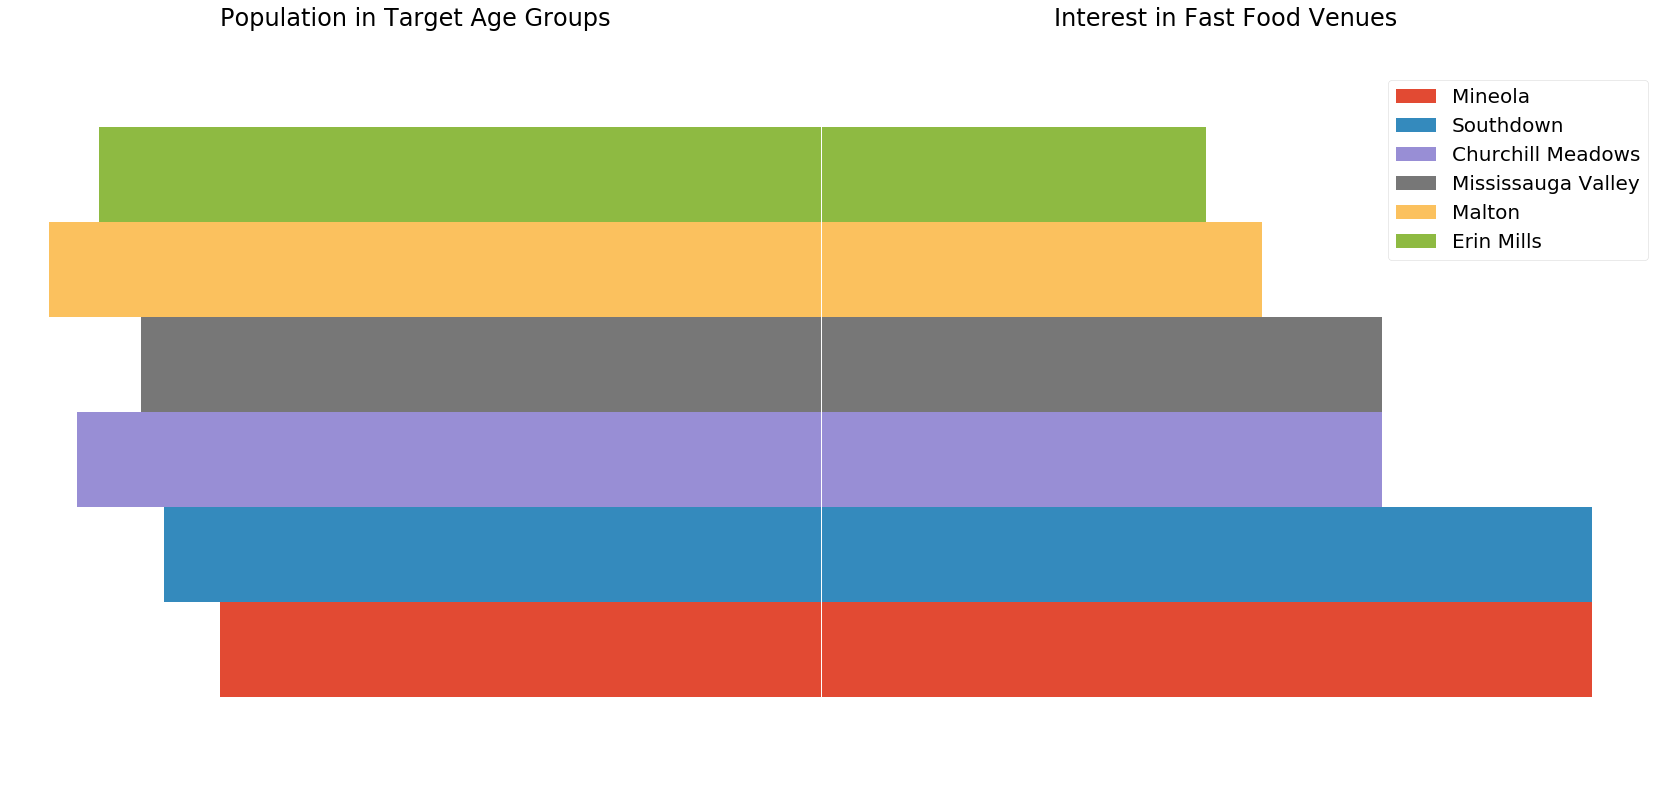

In [27]:
df_plt1 = df_results[['Neighborhood', 'FastFoodPref']].set_index('Neighborhood').transpose()
df_plt2 = df_results[['Neighborhood', 'TargetAge']].set_index('Neighborhood').transpose()

fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot)
ax0.invert_xaxis()

# Subplot 1
df_plt2.plot(kind='barh', figsize=(25, 12), align='edge', width=1.5, legend=False, ax=ax0) # add to subplot 1
ax0.set_title('Population in Target Age Groups')
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_facecolor('white')
ax0.title.set_size(24)

# Subplot 2
df_plt1.plot(kind='barh', figsize=(25, 12), align='edge', width=1.5, ax=ax1) # add to subplot 2
ax1.set_title ('Interest in Fast Food Venues')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_facecolor('white')
ax1.title.set_size(24)
ax1.legend(loc = (0.70, 0.70), facecolor="white", fontsize=20)

plt.subplots_adjust(left=0, bottom=0, right=None, top=None, wspace=0, hspace=0)
plt.show()


It is clear from the horizontal bar plot that we generated, that the "ideal" neighborhood is **Southdown**, due to higher values of both, the share of population in our target age group, and the preference for Fast Food locations, compared to other venues.<br>
<br>
Let's validate this observation by calculating the score and selecting the top neighborhood:

In [28]:
df_results['Score'] = df_results['FastFoodPref'] + df_results['TargetAge']
df_top = df_results.sort_values(by='Score', ascending = False)
df_top.head(1)


,Neighborhood,FastFoodPref,TargetAge,Score
1,Southdown,1.0,0.851266,1.851266


And so we have found a neighborhood in Mississauga that is a perfect candidate for a new Pizza Place!